# ML tutorial 1: Neural network classifiers for distinguishing signals from instrumental noise

Author: Melissa Lopez

Email: m.lopez@uu.nl

In this tutorial, we perform a supervised multi-class classification task using triggers from matched filtering. Our neural network, built with Keras, distinguishes intermediate-mass binary black hole gravitational wave signals from various types of glitches. Through model training and evaluation, we explore how deep learning can separate astrophysical signals from instrumental noise in gravitational wave data.

If you are interested in learning more about the Machine Learning (ML) formalism, I recommend to read [Chapter 4 of my thesis](
  https://research-portal.uu.nl/ws/portalfiles/portal/245781352/phddissertationmelissalopez%20-%206739e41d4dc0a.pdf).

In [ ]:
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau


### A short motivation to finding intermediate-mass binary black holes (IMBH)

The formation of supermassive black holes (SMBH) is not yet fully understood, despite their presence in nearly every galaxy, including the Milky Way.
As stellar evolution predicts, stars with a helium core mass in the range $\sim 32-64\,\text{M}_{\odot}$ leave no remnant due to pair-instability.
Because of this mass gap, a plausible explanation for the formation of (SMBH) is the hierarchical mergers of intermediate-mass black holes (IMBH). Therefore, direct observation of IMBH populations would strengthen the possible evolutionary link between stellar mass black holes and SMBH.

The detection of IMBHs in GW searches remained elusive until the detection of GW190521 during the third observing run.
Despite falling in the sensitivity band of current GWinterferometers, IMBH searches are challenging as few cycles of the signal can be observed with current ground-based detectors.
Moreover, they are also hampered by non-Gaussian transient noise of terretrial origin known as glitches.

### Extremely brief introduction to a GW search as a classification task

A search algorithm is a sequence of operations that inputs the raw data of the interferometer and produces a list of detection events or *triggers*, i.e. potential gravitational wave (GW) candidates, to solve the following hypothesis testing,

**Null hypothesis ($H_{0}$):** the time series $s(t)$ does not contain a \acrshort{gw} $\rightarrow P(h|s) < P_{*}$



**Alternative hypothesis ($H_{a_{0}}$):** the time series $s(t)$ contains a \acrshort{gw} $\rightarrow P(h|s) \geq P_{*}$



given a decision threshold $P_{*}$.

While state-of-the-art search pipelines construct the likelihood ratio $\Lambda$, we can build a supervised ML model that predicts the probability of the input data containing a GW signal based on past evidence, i.e. the model will learn the mapping $h: \mathcal{X} \rightarrow \mathcal{Y}$ between $\mathcal{X}$, the space of the detector's input $X$, and   $\mathcal{Y}$, the space of the targets $y$.

In ML such a supervised task can be defined as a classification problem, that can be *binary* or *multi-class*. If we perform a *binary*classification, we will distinguish between two classes: a *positive* class, usually represented by $y=1$, and a *negative*, usually represented by $y=0$. On the other hand, if we perform a *multi-class* classification, we will distinguish between $C$ classes.

Today we will performa a multi-class classification tasks where we can to differentiate simulated GW signals a.k.a. 'Injections' from non-Gaussian transient noise known as glitches. In particular, we have these classes:


`['Injections', 'Blip' , 'Koi_Fish', 'Low_Frequency_Burst', 'Tomte', 'Whistle','Fast_Scattering']`

To learn a mapping $h$ between the input data and these classes, the ML model minimizes the loss function known as *cross-entropy* via gradient descent. Mathematically,

\begin{equation}
\mathcal{L}(y, \hat{y}) = - \sum_{j}^{C} y_{j}\log{\hat{y}_{j}},
\end{equation}

where $\hat{y}$ represents the probability predicted by the model, $y$ is the target or ground truth and $C$ the number of clasess. Note that this is a generalization of *binary classification* loss function where $C=2$.


These loss functions have several desirable properties: they are easy to compute, differentiable and provide a probabilistic interpretation of the model's output. However, they are sensitive to class imbalance, which occurs when the defined classes have significantly different sizes of samples.


### Hands on tutorial

We can retrieve our dummy dataset with `wget`. This data set is a demo from the larger dataset used in [our paper](https://inspirehep.net/literature/2862532).





In [ ]:
!wget https://ldas-jobs.ligo.caltech.edu/~melissa.lopez/ML_course_mock/GlitchBank/mock_data/dataset_all_H1_bootstrap_O3a.npy

--2025-05-30 00:44:33--  https://ldas-jobs.ligo.caltech.edu/~melissa.lopez/ML_course_mock/GlitchBank/mock_data/dataset_all_H1_bootstrap_O3a.npy
Resolving ldas-jobs.ligo.caltech.edu (ldas-jobs.ligo.caltech.edu)... 131.215.113.160
Connecting to ldas-jobs.ligo.caltech.edu (ldas-jobs.ligo.caltech.edu)|131.215.113.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2116928 (2.0M)
Saving to: ‘dataset_all_H1_bootstrap_O3a.npy.4’

dataset_all_H1_boot 100%[===================>]   2.02M  11.1MB/s    in 0.2s    

2025-05-30 00:44:33 (11.1 MB/s) - ‘dataset_all_H1_bootstrap_O3a.npy.4’ saved [2116928/2116928]



The dataset is a numpy matrix with shape [samples, variables]. Our variables in order are:

- **SNR**: Signal-to-Noise Ratio — measures how strong the signal is compared to the background noise. Higher values suggest stronger, more confident detections.
- **Chisq**: Chi-squared value — indicates how well the observed data matches the expected signal model. Lower values generally mean a better match.
- **Mass1**: Mass of the primary (heavier) compact object, typically given in solar masses.
- **Mass2**: Mass of the secondary (lighter) compact object, also in solar masses.
- **Spin1z**: Dimensionless spin component along the z-axis for the primary object — describes spin magnitude and orientation relative to the orbital angular momentum.
- **Spin2z**: Dimensionless spin component along the z-axis for the secondary object.
- **Class**: Label indicating the type of event — used in classification tasks to distinguish between signal and various types of noise or glitches. The mapping is as follows:
  - 'Injections' → `0` (simulated intermediate-mass black hole signal)
  - 'Blip' → `1`
  - 'Koi_Fish' → `2`
  - 'Low_Frequency_Burst' → `3`
  - 'Tomte' → `4`
  - 'Whistle' → `5`
  - 'Fast_Scattering' → `6`

**Exercise 1:** Load the dataset.
- How many injections are there? How many Blips? Why?
- What is the minimum Mass1? And the maximum?

In [ ]:
data = np.load('dataset_all_H1_bootstrap_O3a.npy')
print(f'There are {data[data[:, -1] == 0].shape[0]} injections')
print(f'There are {data[data[:, -1] == 1].shape[0]} Blips')
print(f'The minimum Mass1 is {np.round(min(data[:, 2]), 2)} and the maximum is {np.round(max(data[:, 2]), 2)} solar masses')

There are 5400 injections
There are 5400 Blips
The minimum Mass1 is 25.86 and the maximum is 537.41 solar masses


The input $X$ to our model will be the `data` matrix with size `[samples, variables - 1]`, because the last variable in the matrix is the target $y$.
Since our task is multi-class and not binary classification we have consider:
- *Categorical target definition:* In a multi-class setting, the target variable must be encoded in a format suitable for distinguishing among multiple classes. This is typically done using one-hot encoding. This allows the model to output a probability distribution over all possible classes.

- *Softmax Activation in the Output Layer:* Instead of using a sigmoid activation function, which is suitable for binary classification, we use a softmax activation function in the final layer. The softmax function  effectively produces a probability distribution across the multiple classes.


In [ ]:
X, y = data[:, :-1], data[:, -1]
# We transform the target into categorical since it is a multi-class task
output_classes = len(np.unique(y))
y = to_categorical(y, num_classes=output_classes)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=0)

Now, we want to build a simple multi-layer perceptron (MLP) with Keras.

Usually we split the data use for supervised classsification into `training`, `validation` and `testing`. `sklearn.model_selection.train_test_split` splits into 75 \% training and 25 \% testing. We still need to split the training into training and validation, which happens after the model is defined, in `model.fit` function, where we use 80\% for training and 20\% for validation.



> **Question:** why do we need training, validation and testing stages? Isn't enough to have training and testing?



With `Sequential` function we define a model with two dense or fully connected layers with `tanh` activation functions. As we mentioned before, the last layer outputs a `softmax` activation to produce a probability distribution of all classes.

With `compile` we call the training and validations stages that depend on the optimizer, the loss definition and the metrics for performance evaluation. Note that we usually use the minimization of the loss and the maximization of the accuracy as part of the same evaluation metric.




> **Question:** why do we need to examine loss AND accuracy to understand the behaviour of our model?



With `fit` we add all the ingredients from `Sequential` and `compile` together, as well as the number of epochs and batch size.

Now, we just excecute! Right?


In [ ]:
input_dim = X_train.shape[1]

# Create a simple MLP model
model = Sequential([
    Dense(32, activation='tanh', input_shape=(input_dim,)),
    Dense(16, activation='tanh'),
    Dense(output_classes, activation='softmax')])

# Compile the model
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4795 - loss: 1.3856 - val_accuracy: 0.6356 - val_loss: 0.9693
Epoch 2/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6370 - loss: 0.9348 - val_accuracy: 0.6624 - val_loss: 0.8836
Epoch 3/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6660 - loss: 0.8655 - val_accuracy: 0.6721 - val_loss: 0.8374
Epoch 4/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6777 - loss: 0.8241 - val_accuracy: 0.6972 - val_loss: 0.7824
Epoch 5/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6947 - loss: 0.7899 - val_accuracy: 0.7150 - val_loss: 0.7578
Epoch 6/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7009 - loss: 0.7690 - val_accuracy: 0.6988 - val_loss: 0.7661
Epoch 7/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7098 - loss: 0.7461 - val_accuracy: 0.7265 - val_loss: 0.7100
Epoch 8/20
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7162 - loss: 0.7186 - 

I wrote some functions to help us visualize what is going on in the network.

296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


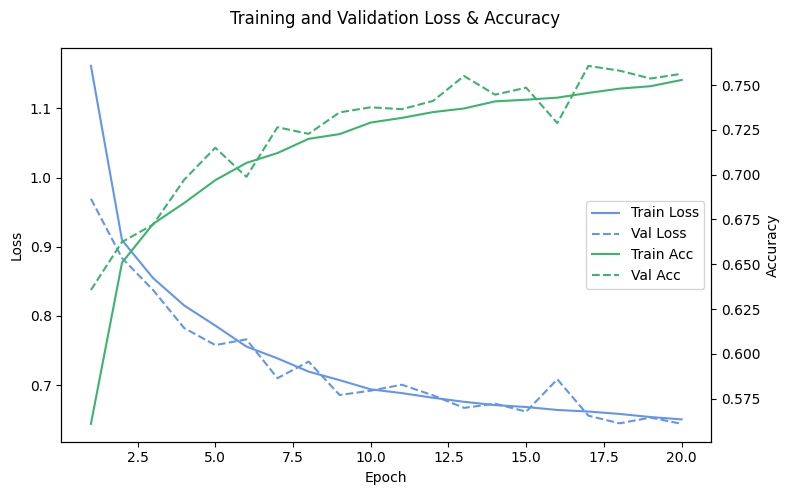

Train accuracy: 0.7528, Validation accuracy: 0.7563, Test accuracy: 0.7453


In [ ]:
def plot_history(history):
  epochs = range(1, len(history.history['loss']) + 1)

  fig, ax1 = plt.subplots(figsize=(8, 5))

  # Plot loss on left y-axis
  ax1.plot(epochs, history.history['loss'], c='cornflowerblue', linestyle='solid', label='Train Loss')
  ax1.plot(epochs, history.history['val_loss'], c='cornflowerblue', linestyle='dashed', label='Val Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.tick_params(axis='y')

  # Create second y-axis for accuracy
  ax2 = ax1.twinx()
  ax2.plot(epochs, history.history['accuracy'], c='mediumseagreen', linestyle='solid', label='Train Acc')
  ax2.plot(epochs, history.history['val_accuracy'], c='mediumseagreen', linestyle='dashed', label='Val Acc')
  ax2.set_ylabel('Accuracy')
  ax2.tick_params(axis='y')

  # Title and legends
  fig.suptitle('Training and Validation Loss & Accuracy')
  lines1, labels1 = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

  plt.tight_layout()
  plt.show()

  max_acc_train = history.history['accuracy'][-1]
  max_acc_val = history.history['val_accuracy'][-1]
  return max_acc_train, max_acc_val

def get_test_accuracy(history):

  y_pred_prob = model.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)
  y_true = np.argmax(y_test, axis=1)

  test_acc = accuracy_score(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)
  return test_acc, cm

test_acc, cm = get_test_accuracy(history)
max_acc_train, max_acc_val = plot_history(history)
print(f'Train accuracy: {max_acc_train:.4f}, Validation accuracy: {max_acc_val:.4f}, Test accuracy: {test_acc:.4f}')

**Exercise 2:** What are the main problems with this network? Let's brainstorm a bit.

**Exercise 3:** Can we do better? Can we increase accuracy ~10%?

Some ideas:

- Scaling of the data. Why is it important?
- Another architecture?
- Learning rate scheduler?
- Batch size? Number of epochs?
- Regularization layers? e.g. Dropout

You can also use [Optuna](https://optuna.org/), but honestly I never use it.

In [ ]:
X, y = data[:, :-1], data[:, -1]
output_classes = len(np.unique(y))
y = to_categorical(y, num_classes=output_classes)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_scaled, y, random_state=0)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5539 - loss: 1.1976 - val_accuracy: 0.6679 - val_loss: 0.8586 - learning_rate: 0.0010
Epoch 2/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6625 - loss: 0.8789 - val_accuracy: 0.6875 - val_loss: 0.8174 - learning_rate: 0.0010
Epoch 3/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6810 - loss: 0.8330 - val_accuracy: 0.7004 - val_loss: 0.7955 - learning_rate: 0.0010
Epoch 4/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6873 - loss: 0.8098 - val_accuracy: 0.7095 - val_loss: 0.7718 - learning_rate: 0.0010
Epoch 5/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6993 - loss: 0.7867 - val_accuracy: 0.7025 - val_loss: 0.7637 - learning_rate: 0.0010
Epoch 6/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7017 - loss: 0.7543 - val_accuracy: 0.7273 - val_loss: 0.7229 - learning_rate: 0.0010
Epoch 7/200
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7098 - loss: 0.7365 - val_a

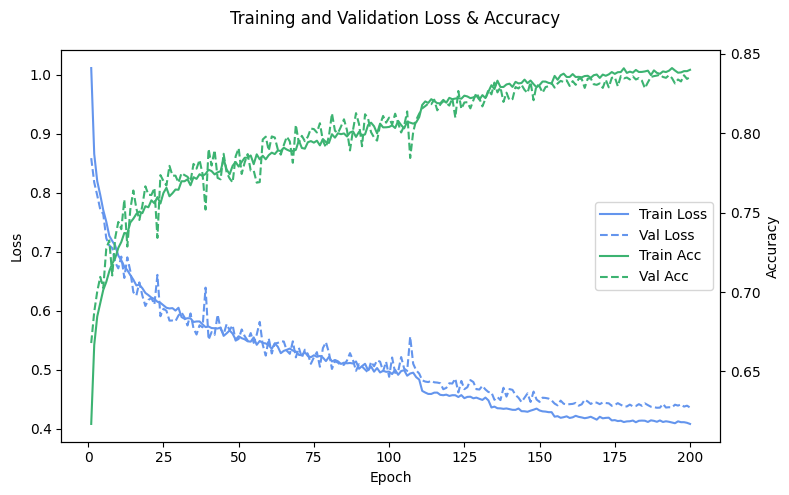

Train accuracy: 0.8398, Validation accuracy: 0.8353, Test accuracy: 0.8375


In [ ]:
input_dim = X_train.shape[1]

# Create a simple MLP model
model = Sequential([
    Dense(64, activation='selu', input_shape=(input_dim,)),
    Dense(32, activation='selu'),
    Dense(16, activation='selu'),
    Dense(32, activation='selu'),
    Dense(64, activation='selu'),
    Dropout(0.1),
    Dense(output_classes, activation='softmax')])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, shuffle=True,  callbacks=[reduce_lr])

test_acc, cm = get_test_accuracy(history)
max_acc_train, max_acc_val = plot_history(history)
print(f'Train accuracy: {max_acc_train:.4f}, Validation accuracy: {max_acc_val:.4f}, Test accuracy: {test_acc:.4f}')


Given this decision rule, there are two correct and two erroneous outcomes. If we correctly predict that a gravitational wave (GW) signal is present or absent in the time series \( s \), we refer to these cases as a *true positive* (TP) or *true negative* (TN), respectively. Conversely, if we incorrectly predict that a GW signal is present when it is not, this is called a *false positive* (FP), or more commonly in the GW field, a *false alarm*. If we incorrectly predict that a GW signal is absent when it is actually present, we refer to this as a *false negative* (FN), or a *false dismissal*. In machine learning (ML), these outcomes are typically summarized in a *confusion matrix*.

**Exercise 4:** Plot in a heatmap the confussion matrix.

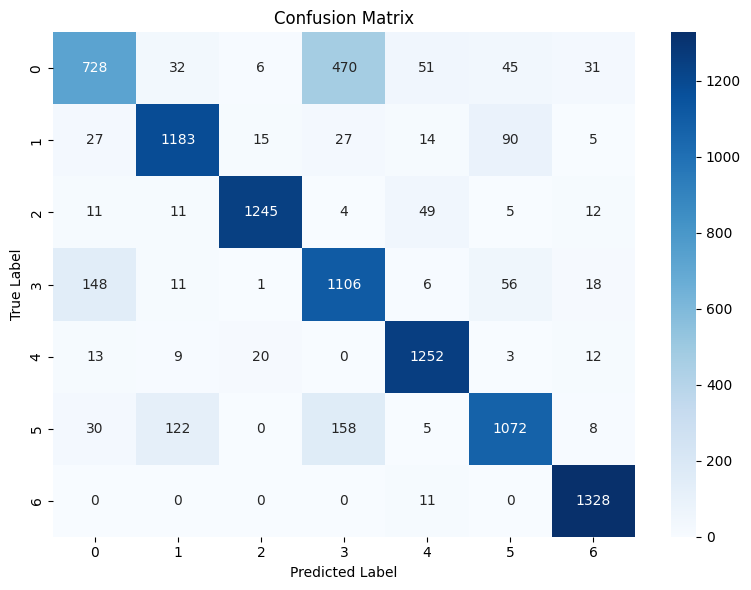

In [ ]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()